In [1]:
import requests

def get_live_ethereum_price():
    # URL for the CoinGecko API endpoint
    url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'

    try:
        # Sending a GET request to the API
        response = requests.get(url)
        
        # Raise an exception if the request was unsuccessful
        response.raise_for_status()
        
        # Parse the JSON response
        data = response.json()
        
        # Extracting the Ethereum price in USD
        ethereum_price = data['ethereum']['usd']
        
        return ethereum_price
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Fetch and print the live Ethereum price
eth_price = get_live_ethereum_price()
if eth_price is not None:
    print(f"The current price of Ethereum is ${eth_price} USD")
else:
    print("Failed to retrieve the Ethereum price.")


The current price of Ethereum is $2989.11 USD


In [2]:
import requests
import pandas as pd
from datetime import datetime

# Define the endpoint and parameters
def fetch_historical_prices(start_date, end_date, currency='usd'):
    url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range"
    params = {
        'vs_currency': currency,
        'from': start_date,
        'to': end_date
    }

    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code}")
    
    data = response.json()
    return data

# Convert the data into a pandas DataFrame
def create_dataframe(prices_data):
    prices = prices_data.get('prices', [])
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

def main():
    # Define your date range in Unix timestamps (seconds since epoch)
    start_date = int(datetime(2024, 1, 1).timestamp())
    end_date = int(datetime(2024, 1, 31).timestamp())

    # Fetch historical prices
    data = fetch_historical_prices(start_date, end_date)
    
    # Create a DataFrame
    df = create_dataframe(data)
    
    # Print DataFrame or save to a file
    print(df)
    df.to_csv('ethereum_prices.csv')




In [3]:
def load_ethereum_prices(file_path):
    """
    Load Ethereum prices from a CSV file into a pandas DataFrame.
    
    Args:
    - file_path (str): The path to the CSV file.
    
    Returns:
    - pd.DataFrame: DataFrame containing Ethereum prices.
    """
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')
        return df
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return pd.DataFrame()  # Return an empty DataFrame if file is not found
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        return pd.DataFrame()  # Return an empty DataFrame if file is empty
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
        return pd.DataFrame()  # Return an empty DataFrame if there is a parsing error
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame for any other exceptions

In [4]:
df = load_ethereum_prices("ethereum_prices.csv")

In [5]:
import numpy as np

def calculate_indicators(df):
    """
    Calculate 20-day and 50-day moving averages, 7-day RSI, and 14-day Bollinger Bands.

    Args:
    - df (pd.DataFrame): DataFrame containing 'timestamp' and 'price' columns.

    Returns:
    - pd.DataFrame: DataFrame with added columns for moving averages, RSI, and Bollinger Bands.
    """
    # Ensure the DataFrame is sorted by timestamp
    df = df.sort_index()
    
    # Calculate 20-day and 50-day moving averages
    df['MA_20'] = df['price'].rolling(window=20).mean()
    df['MA_50'] = df['price'].rolling(window=50).mean()
    
    # Calculate 7-day RSI
    delta = df['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=7).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=7).mean()
    rs = gain / loss
    df['RSI_7'] = 100 - (100 / (1 + rs))
    
    # Calculate 14-day Bollinger Bands
    df['MA_14'] = df['price'].rolling(window=14).mean()
    df['STD_14'] = df['price'].rolling(window=14).std()
    df['Bollinger_Upper'] = df['MA_14'] + (df['STD_14'] * 2)
    df['Bollinger_Lower'] = df['MA_14'] - (df['STD_14'] * 2)
    return df

In [6]:
df = calculate_indicators(df)

In [7]:
df =  df.dropna()

In [8]:
df

,price,MA_20,MA_50,RSI_7,MA_14,STD_14,Bollinger_Upper,Bollinger_Lower
timestamp,,,,,,,,
2024-01-03 01:01:02.974,2364.637241,2378.582510,2342.423756,60.569564,2369.803461,13.350560,2396.504580,2343.102341
2024-01-03 02:00:05.572,2372.964720,2378.282736,2344.249565,59.395045,2368.277247,11.411313,2391.099873,2345.454622
2024-01-03 03:00:36.300,2370.922428,2377.966726,2345.736314,57.369734,2367.253163,10.365434,2387.984032,2346.522295
2024-01-03 04:00:31.447,2370.320736,2377.184850,2347.144110,60.192775,2365.308917,5.790800,2376.890518,2353.727316
2024-01-03 05:00:25.725,2367.334424,2373.829207,2348.613633,50.034777,2364.871697,5.342092,2375.555880,2354.187513
...,...,...,...,...,...,...,...,...
2024-01-30 19:00:30.973,2374.529986,2320.649218,2291.007180,88.603200,2323.602441,26.937934,2377.478309,2269.726574
2024-01-30 20:00:31.763,2375.736405,2323.587799,2293.123384,100.000000,2328.679236,29.654197,2387.987630,2269.370841
2024-01-30 21:00:27.073,2376.857633,2327.135404,2295.438149,100.000000,2333.844159,31.375191,2396.594541,2271.093778


In [9]:
import matplotlib.pyplot as plt

def plot_dataframe(df):
    """
    Plot the columns of the DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'timestamp', 'price', 'MA_20', 'MA_50', 
      'RSI_7', 'MA_14', 'STD_14', 'Bollinger_Upper', 'Bollinger_Lower'.
    """
    # Ensure the DataFrame is sorted by timestamp
    df = df.sort_index()
    
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

    # Plot price and moving averages
    axs[0].plot(df.index, df['price'], label='Price', color='blue')
    axs[0].plot(df.index, df['MA_20'], label='20-day MA', color='orange')
    axs[0].plot(df.index, df['MA_50'], label='50-day MA', color='green')
    axs[0].set_ylabel('Price')
    axs[0].legend()
    axs[0].set_title('Price and Moving Averages')

    # Plot RSI
    axs[1].plot(df.index, df['RSI_7'], label='7-day RSI', color='purple')
    axs[1].axhline(y=70, color='red', linestyle='--', label='Overbought')
    axs[1].axhline(y=30, color='green', linestyle='--', label='Oversold')
    axs[1].set_ylabel('RSI')
    axs[1].legend()
    axs[1].set_title('Relative Strength Index (RSI)')

    # Plot Bollinger Bands
    axs[2].plot(df.index, df['price'], label='Price', color='blue')
    axs[2].plot(df.index, df['Bollinger_Upper'], label='Bollinger Upper Band', color='red', linestyle='--')
    axs[2].plot(df.index, df['Bollinger_Lower'], label='Bollinger Lower Band', color='green', linestyle='--')
    axs[2].fill_between(df.index, df['Bollinger_Lower'], df['Bollinger_Upper'], color='lightgrey', alpha=0.5)
    axs[2].set_xlabel('Timestamp')
    axs[2].set_ylabel('Price')
    axs[2].legend()
    axs[2].set_title('Bollinger Bands')

    # Improve layout and show plot
    plt.tight_layout()
    plt.savefig("out.png")
    plt.show()

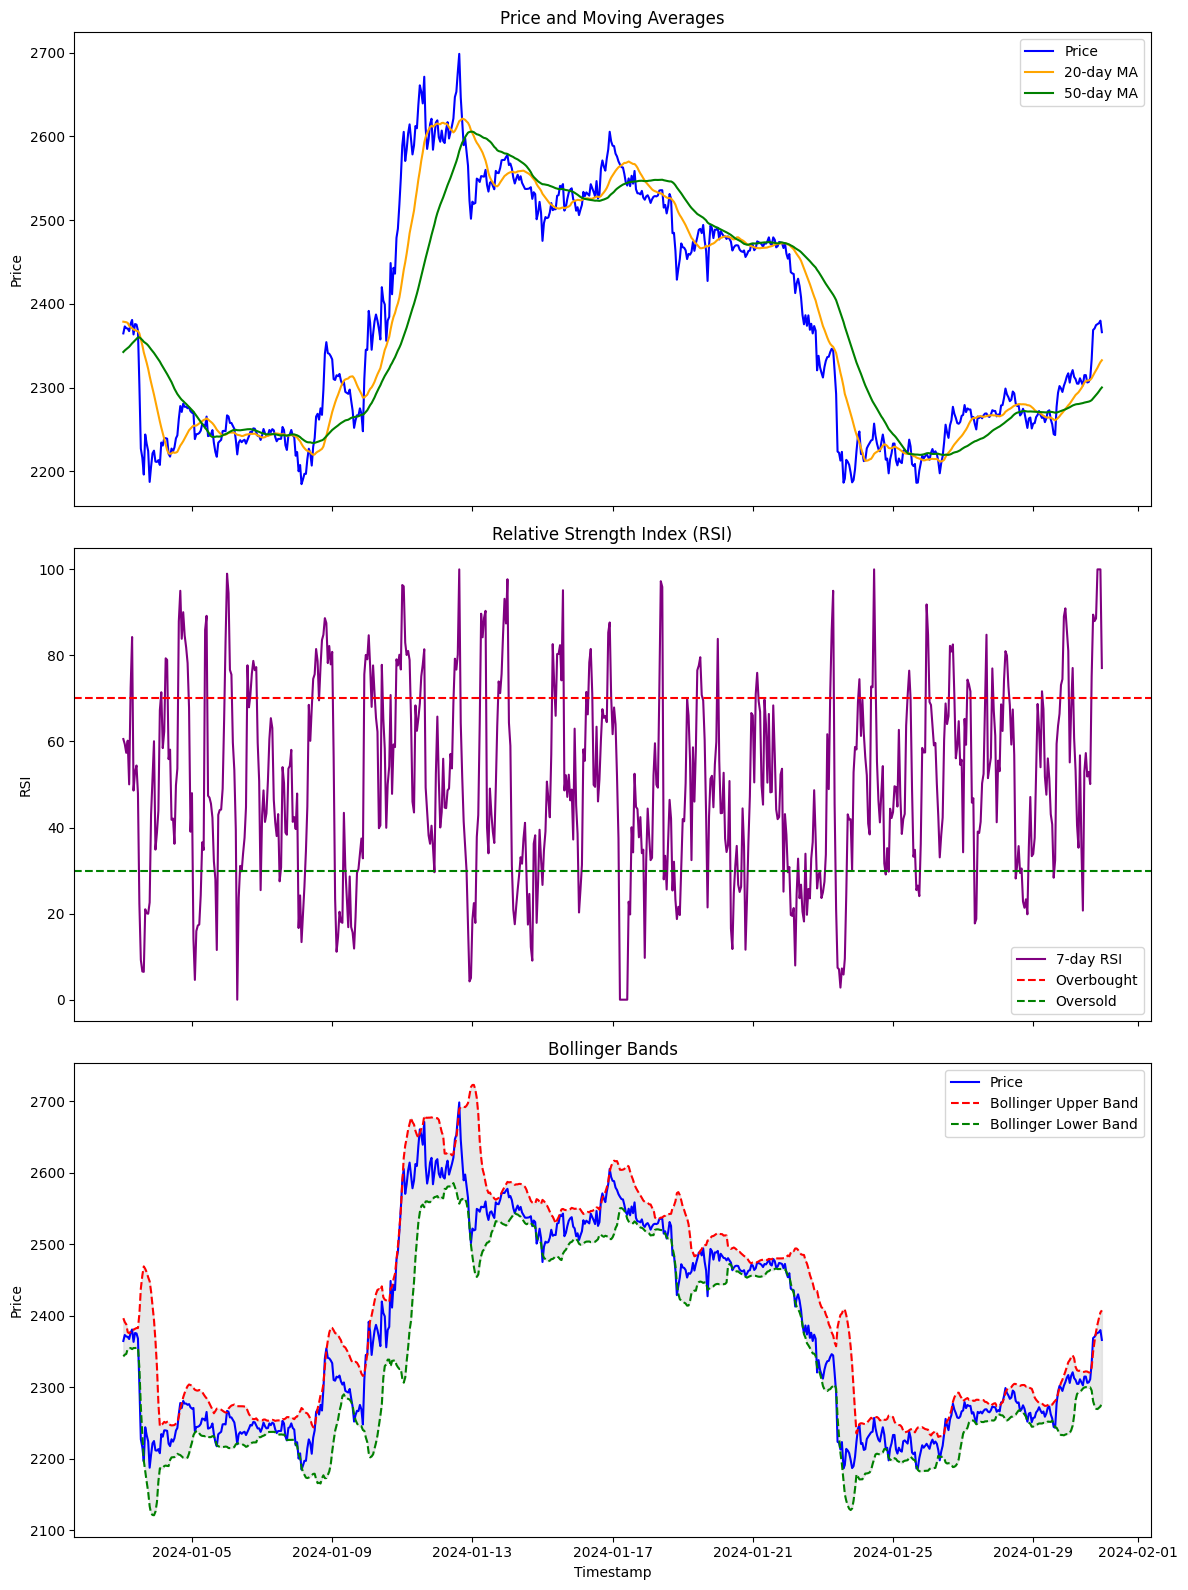

In [10]:
plot_dataframe(df)

In [11]:
import requests

def get_eth_price():
    url = "https://api.binance.com/api/v3/ticker/price?symbol=ETHUSDT"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        price = data['price']
        return float(price)
    else:
        raise Exception("Error fetching data from Binance API")

if __name__ == "__main__":
    try:
        eth_price = get_eth_price()
        print(f"The current price of Ethereum (ETH) is: ${eth_price}")
    except Exception as e:
        print(f"An error occurred: {e}")


The current price of Ethereum (ETH) is: $2994.19


In [12]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



# Creating a DataFrame
#df = pd.DataFrame(df)
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df.set_index('timestamp', inplace=True)

# Features and target
X = df.drop('price', axis=1)
y = df['price']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf.fit(X_train, y_train)

# Making predictions
y_pred = rf.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Predicting future prices
future_data = {
    'MA_20': [df['MA_20'].iloc[-1]],
    'MA_50': [df['MA_50'].iloc[-1]],
    'RSI_7': [df['RSI_7'].iloc[-1]],
    'MA_14': [df['MA_14'].iloc[-1]],
    'STD_14': [df['STD_14'].iloc[-1]],
    'Bollinger_Upper': [df['Bollinger_Upper'].iloc[-1]],
    'Bollinger_Lower': [df['Bollinger_Lower'].iloc[-1]]
}

future_df = pd.DataFrame(future_data)
future_price_pred = rf.predict(future_df)

print(f"Predicted Future Price: {future_price_pred[0]}")


Mean Squared Error: 149.43450183596164
R^2 Score: 0.9919467855990567
Predicted Future Price: 2369.238594915228


In [24]:
#future_df
#df
[df['MA_20'].iloc[-1]]

[2332.5826245548387]

In [22]:
df.iloc[-1]

price              2366.072109
MA_20              2332.582625
MA_50              2300.062250
RSI_7                77.074020
MA_14              2342.982323
STD_14               32.267951
Bollinger_Upper    2407.518224
Bollinger_Lower    2278.446422
Name: 2024-01-30 23:00:24.928000, dtype: float64